In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import sklearn.manifold
import sklearn.linear_model
from scipy.io import loadmat
import jax
from jax.nn import sigmoid

Load Gabor-filtered outputs from Matlab (which come from https://github.com/mhaghighat/gabor with default parameters)

In [2]:
filtered_test = np.loadtxt('filtered_test.csv', delimiter=',').T
filtered_training = np.loadtxt('filtered_training.csv', delimiter=',').T

In [3]:
mnist_data = loadmat('mnist.mat', squeeze_me=True)

In [4]:
y_test = mnist_data['test']['labels'].item()
y_training = mnist_data['training']['labels'].item()

In [13]:
tsne = sklearn.manifold.TSNE()

In [14]:
tsne_training = tsne.fit_transform(filtered_training[:5000])

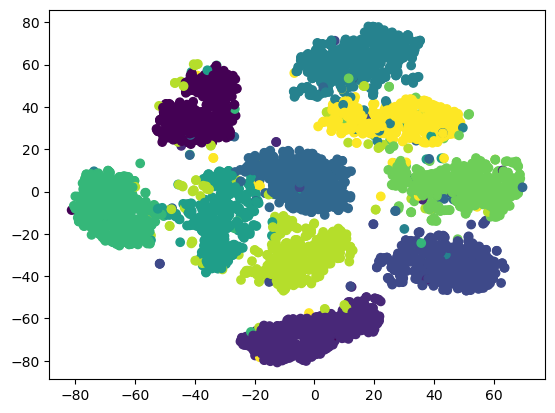

In [15]:
plt.scatter(*zip(*tsne_training), c=y_training[:5000])

In [5]:
def shift_dists(train_in, test_in, y):
    train_0, train_1 = train_in[y == 0], train_in[y==1]
    mean_0, mean_1 = train_0.mean(axis=0), train_1.mean(axis=0)
    shift = -(mean_0+mean_1)/2
    return train_in+shift, test_in+shift

In [6]:
def scale_dists(train_in, test_in, y):
    train_0, train_1 = train_in[y == 0], train_in[y==1]
    mean_0, mean_1 = train_0.mean(axis=0), train_1.mean(axis=0)
    scale = jnp.sqrt(mean_1 @ mean_1)
    return train_in/scale, test_in/scale

In [7]:
mnist_training_01, y_training_01 = filtered_training[y_training < 2], y_training[y_training < 2]
mnist_test_01, y_test_01 = filtered_test[y_test < 2], y_test[y_test < 2]
train, test = shift_dists(mnist_training_01, mnist_test_01, y_training_01)
train_0, train_1 = train[y_training_01 == 0], train[y_training_01==1]
mean_1 = train[y_training_01 == 1].mean(axis=0)
train_0, train_1 = train[y_training_01 == 0], train[y_training_01==1]

In [8]:

tsne_training_01 = tsne.fit_transform(train)

NameError: name 'tsne' is not defined

NameError: name 'tsne_training_01' is not defined

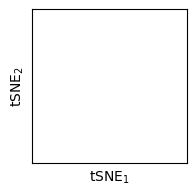

In [9]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(2,2)
ax.set_xlabel('tSNE$_1$')
ax.set_xticks([]), ax.set_yticks([])
ax.set_ylabel('tSNE$_2$')
ax.scatter(*zip(*tsne_training_01[:5000]), s=1.5,c=y_training_01[:5000])
fig.savefig('mnist_dist.svg')

In [15]:
eta = 0.001
l2_reg0 = 1
def sgd_iter(w: jnp.array, mean_1: jnp.array, xy_train: jnp.array):
    x, y = xy_train[1:], xy_train[0]
    y_hat = sigmoid(w @ x)
    # y_hat = 1/2+1/2*jax.scipy.special.erf(jnp.sqrt(jnp.pi)/4*w @ x)
    w +=  eta*((y-y_hat)*x - l2_reg0*w)
    norm_w = jnp.sqrt(w @ w)
    acc_test = ((jnp.einsum('i,bi -> b', w, test)>0) == y_test_01).mean()
    return w, jnp.r_[jnp.array([norm_w, w@mean_1 / norm_w, acc_test]),w]

In [16]:
def normalize(vec: jnp.array):
    return vec / jnp.sqrt(vec @ vec)

In [17]:
train_ds = jnp.c_[y_training_01, train]

In [18]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
n_x = mnist_training_01.shape[1]
w_init = jax.random.normal(subkey, shape=(n_x,))

In [19]:
def get_results_curve(seed, eta=0.001, l2_reg0=1):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    train_ds = jnp.c_[y_training_01, train]
    train_ds = jax.random.permutation(subkey, train_ds)
    w_fin, results = jax.lax.scan(lambda w, x: sgd_iter(w, mean_1, x), w_init, train_ds)
    return results

In [20]:
all_results = jax.vmap(lambda seed: get_results_curve(seed))(jnp.arange(10))

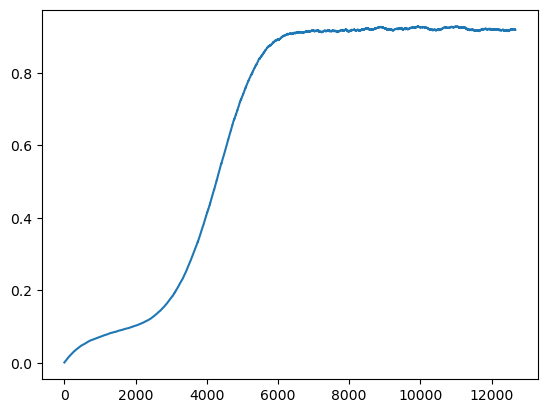

In [21]:
plt.plot(all_results.mean(axis=0)[:, 1]/jnp.sqrt(mean_1 @ mean_1))

In [22]:
cov_0 = np.cov(train_0.T)
cov_1 = np.cov(train_1.T)

In [23]:
@jax.jit
def Phi(z: jnp.array) -> jnp.array:
    return 1/2*(1+jax.scipy.special.erf(z/jnp.sqrt(2)))

In [24]:
def eq_mean(w, mean_1, sigma_0, sigma_1, lam):
    a_1 = w @ mean_1*jnp.sqrt(jnp.pi/8)
    b_0_sq = w @ (sigma_0 @ w)*jnp.pi/8
    b_1_sq = w @ (sigma_1 @ w)*jnp.pi/8
    return 1/2*mean_1*(1-Phi(a_1/jnp.sqrt(1+b_1_sq))) + 1/2*mean_1*(1-Phi(a_1/jnp.sqrt(1+b_0_sq)))\
        - 1/8 * ((sigma_1@w)/jnp.sqrt(1+b_1_sq)*jnp.exp(-a_1**2/(2*(1+b_1_sq)))\
                 + (sigma_0@w)/jnp.sqrt(1+b_0_sq)*jnp.exp(-a_1**2/(2*(1+b_0_sq)))) - lam*w

In [25]:
def eq_iter(w, eps, mean_1, sigma_0, sigma_1, lam, i_iter):
    """
    Simple Euler ODE integration of eq_mean.
    """
    return w+eps*eq_mean(w, mean_1, sigma_0, sigma_1, lam), \
    jnp.r_[w@mean_1/(jnp.sqrt(w @ w) * jnp.sqrt(mean_1 @ mean_1)),\
           1/4*jax.scipy.special.erfc(-mean_1@w/(jnp.sqrt(2*w @ (sigma_1 @ w)))) + \
          1/4*jax.scipy.special.erfc(-mean_1@w/(jnp.sqrt(2*w @ (sigma_0 @ w))))]
                                                        

In [26]:
eps = 0.0001
lam = 1
w_eq_end, aligns = jax.lax.scan(lambda w, i: eq_iter(w, eps, mean_1, cov_0, cov_1, lam, i), w_init, jnp.arange(int(12/eps)))

In [27]:
results_mean = all_results.mean(axis=0)
results_std = all_results.std(axis=0)

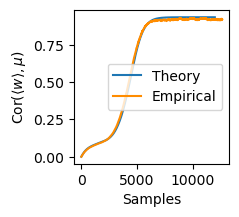

In [28]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(2,2)
ax.set_xlabel('Samples')
ax.set_ylabel('Cor($\\langle w\\rangle,\\mu)$')
plt.plot(aligns[::int(eta/eps),0], label="Theory")
plt.plot(results_mean[:, 1]/jnp.sqrt(mean_1 @ mean_1), label="Empirical", c="darkorange")
plt.fill_between(np.arange(len(results_mean)),
                 (results_mean-results_std)[:,1]/jnp.sqrt(mean_1 @ mean_1), (results_mean+results_std)[:,1]/jnp.sqrt(mean_1 @ mean_1), facecolor="darkorange", alpha=0.5)
plt.legend()
plt.savefig('mnist_cor.svg')

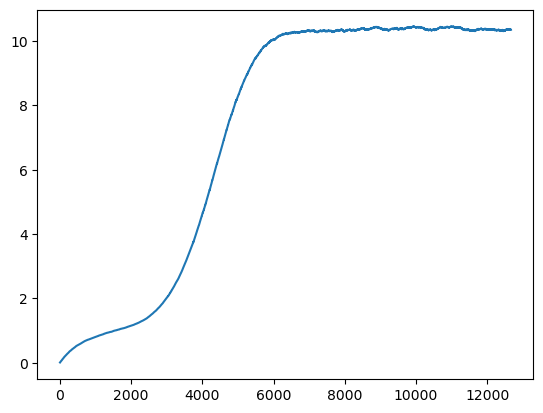

In [29]:
plt.plot(results_mean[:,1])

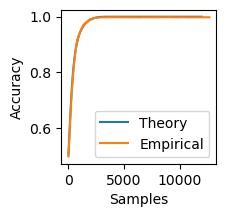

In [30]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(2,2)
plt.xlabel("Samples")
plt.ylabel("Accuracy")
plt.plot(aligns[::int(eta/eps),1], label="Theory")
plt.fill_between(np.arange(len(results_mean)),
                 (results_mean-results_std)[:,2], (results_mean+results_std)[:,2], facecolor="darkorange", alpha=0.5)
plt.plot(results_mean[:, 2], label="Empirical")
plt.legend()
plt.savefig('mnist_acc.svg')